In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
len(X_train)

60000

In [4]:
len(X_test)

10000

In [5]:
X_train[0].shape

(28, 28)

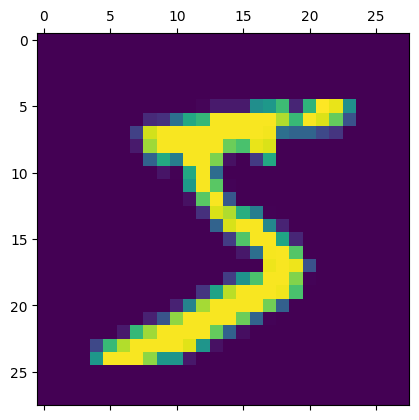

In [6]:
plt.matshow(X_train[0])

In [7]:
y_train[0]

5

In [8]:
X_train = X_train / 255
X_test = X_test / 255

In [9]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [10]:
X_train_flattened.shape

(60000, 784)

## Using Flatten layer so that we don't have to call .reshape on input dataset

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)



Epoch 1/5


1875/1875 [==============================] - 5s 2ms/step - loss: 0.2747 - accuracy: 0.9218
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1256 - accuracy: 0.9630
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0880 - accuracy: 0.9735
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0668 - accuracy: 0.9799
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0527 - accuracy: 0.9843


In [12]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0819 - accuracy: 0.9747


[0.0819280669093132, 0.9746999740600586]

In [13]:
model.save("./saved_model/")

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


# (1) Post training quantization

### Without quantization

In [14]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

### With quantization

In [15]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [16]:
len(tflite_model)

320004

In [17]:
len(tflite_quant_model)

84880

In [18]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [19]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

# (2) Quantization aware training

In [20]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

ValueError: Unable to clone model. This generally happens if you used custom Keras layers or objects in your model. Please specify them via `quantize_scope` for your calls to `quantize_model` and `quantize_apply`. [Layer <tf_keras.src.layers.reshaping.flatten.Flatten object at 0x0000015B46465C50> supplied to wrapper is not a supported layer type. Please ensure wrapped layer is a valid Keras layer.].

In [ ]:
q_aware_model.fit(X_train, y_train, epochs=1)

In [ ]:
q_aware_model.evaluate(X_test, y_test)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

In [ ]:
len(tflite_qaware_model)

In [ ]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)